In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# custom imports
PROJECT_ROOT = Path(__file__).resolve().parent.parent if "__file__" in locals() else Path("../../..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.eval.evaluation.loader import reduce_mem_usage
from src.eval.evaluation.style import apply_shap_style, get_shap_cmap, SHAP_BLUE, SHAP_RED, save_plot

apply_shap_style()

In [ ]:
def calculate_returns(df, value_col, horizons_min, direction='past', id_col='delivery_start',
                      time_col='snapshot_times'):
    """
    Berechnet Returns (Differenzen) in die Vergangenheit ODER Zukunft.

    Args:
        direction (str): 'past' (für Features: t - k) oder 'future' (für Labels: t + k).
    """
    # 1. Sortieren & Typisieren (wie gehabt)
    df = df.sort_values(by=[time_col]).reset_index(drop=True)
    if not pd.api.types.is_datetime64_any_dtype(df[time_col]):
        df[time_col] = pd.to_datetime(df[time_col])

    lookup_df = df[[id_col, time_col, value_col]].copy()
    lookup_df.columns = [id_col, 'lookup_timestamp', 'lookup_value']

    for horizon in tqdm(horizons_min, desc=f"Calc {direction} returns for {value_col}"):
        target_time_col = f'target_time_{horizon}m'

        # 2. Zielzeit & Suchrichtung bestimmen
        if direction == 'past':
            df[target_time_col] = df[time_col] - pd.Timedelta(minutes=horizon)
            merge_dir = 'backward'  # Suche <= Zielzeit
        else:  # future
            df[target_time_col] = df[time_col] + pd.Timedelta(minutes=horizon)
            merge_dir = 'forward'  # Suche >= Zielzeit

        # 3. Merge As-Of
        merged = pd.merge_asof(
            left=df,
            right=lookup_df,
            left_on=target_time_col,
            right_on='lookup_timestamp',
            by=id_col,
            direction=merge_dir
        )

        # 4. Validierung
        if direction == 'past':
            # Der gefundene Wert muss in der Vergangenheit liegen (kleiner als Jetzt)
            valid_mask = merged['lookup_timestamp'] < df[time_col]
            # Return: Aktuell - Vergangenheit
            diff = df[value_col] - merged['lookup_value']
        else:
            # Der gefundene Wert muss in der Zukunft liegen (größer als Jetzt)
            valid_mask = merged['lookup_timestamp'] > df[time_col]
            # Return: Zukunft - Aktuell (Standard für Labels)
            diff = merged['lookup_value'] - df[value_col]

        # 5. Zuweisen
        suffix = 'prev' if direction == 'past' else 'next'
        new_col_name = f'{value_col}_return_{suffix}_{horizon}min'

        df[new_col_name] = np.where(valid_mask, diff, np.nan)
        df.drop(columns=[target_time_col], inplace=True)

    return df

# analyze mid price and spread


In [2]:
MM_PATH = "/Users/robin/PycharmProjects/Masterarbeit/data/parquet/04-pivoted"

# COLS_TO_READ = [
#     "snapshot_times",
#     "delivery_start",
#     *[f"quantity_{level}_{side}" for level in range(1, 11) for side in ["ask", "bid"]],
#     *[f"price_{level}_{side}" for level in range(1, 11) for side in ["ask", "bid"]],
# ]

COLS_TO_READ = ["price_1_ask", "quantity_1_ask", "delivery_start", "snapshot_times"]

In [3]:

data = pd.DataFrame()

for file in tqdm(Path(MM_PATH).glob("*.parquet"), desc="Loading Parquet files"):
    df = pd.read_parquet(file, columns=COLS_TO_READ).pipe(reduce_mem_usage)
    data = pd.concat([data, df], ignore_index=True)

Loading Parquet files: 10it [00:00, 43.28it/s]

Memory usage of dataframe is 5.23 MB
Memory usage after optimization is: 5.23 MB
Decreased by 0.0%
Memory usage of dataframe is 3.95 MB
Memory usage after optimization is: 3.95 MB
Decreased by 0.0%
Memory usage of dataframe is 4.57 MB
Memory usage after optimization is: 4.57 MB
Decreased by 0.0%
Memory usage of dataframe is 4.73 MB
Memory usage after optimization is: 4.73 MB
Decreased by 0.0%
Memory usage of dataframe is 4.81 MB
Memory usage after optimization is: 4.81 MB
Decreased by 0.0%
Memory usage of dataframe is 5.03 MB
Memory usage after optimization is: 5.03 MB
Decreased by 0.0%
Memory usage of dataframe is 5.12 MB
Memory usage after optimization is: 5.12 MB
Decreased by 0.0%
Memory usage of dataframe is 4.79 MB
Memory usage after optimization is: 4.79 MB
Decreased by 0.0%
Memory usage of dataframe is 4.89 MB
Memory usage after optimization is: 4.89 MB
Decreased by 0.0%
Memory usage of dataframe is 4.93 MB
Memory usage after optimization is: 4.93 MB
Decreased by 0.0%
Memory usa

Loading Parquet files: 22it [00:00, 43.93it/s]

Memory usage of dataframe is 5.09 MB
Memory usage after optimization is: 5.09 MB
Decreased by 0.0%
Memory usage of dataframe is 4.78 MB
Memory usage after optimization is: 4.78 MB
Decreased by 0.0%
Memory usage of dataframe is 5.21 MB
Memory usage after optimization is: 5.21 MB
Decreased by 0.0%
Memory usage of dataframe is 5.16 MB
Memory usage after optimization is: 5.16 MB
Decreased by 0.0%
Memory usage of dataframe is 4.97 MB
Memory usage after optimization is: 4.97 MB
Decreased by 0.0%
Memory usage of dataframe is 5.27 MB
Memory usage after optimization is: 5.27 MB
Decreased by 0.0%
Memory usage of dataframe is 5.20 MB
Memory usage after optimization is: 5.20 MB
Decreased by 0.0%
Memory usage of dataframe is 5.21 MB
Memory usage after optimization is: 5.21 MB
Decreased by 0.0%
Memory usage of dataframe is 4.86 MB


Loading Parquet files: 27it [00:00, 39.26it/s]

Memory usage after optimization is: 4.86 MB
Decreased by 0.0%
Memory usage of dataframe is 4.75 MB
Memory usage after optimization is: 4.75 MB
Decreased by 0.0%
Memory usage of dataframe is 4.86 MB
Memory usage after optimization is: 4.86 MB
Decreased by 0.0%
Memory usage of dataframe is 5.09 MB
Memory usage after optimization is: 5.09 MB
Decreased by 0.0%
Memory usage of dataframe is 5.03 MB
Memory usage after optimization is: 5.03 MB
Decreased by 0.0%
Memory usage of dataframe is 5.01 MB
Memory usage after optimization is: 5.01 MB
Decreased by 0.0%
Memory usage of dataframe is 5.09 MB
Memory usage after optimization is: 5.09 MB
Decreased by 0.0%


Loading Parquet files: 32it [00:00, 34.85it/s]

Memory usage of dataframe is 4.63 MB
Memory usage after optimization is: 4.63 MB
Decreased by 0.0%
Memory usage of dataframe is 4.96 MB
Memory usage after optimization is: 4.96 MB
Decreased by 0.0%
Memory usage of dataframe is 4.70 MB
Memory usage after optimization is: 4.70 MB
Decreased by 0.0%
Memory usage of dataframe is 4.82 MB
Memory usage after optimization is: 4.82 MB
Decreased by 0.0%
Memory usage of dataframe is 4.65 MB
Memory usage after optimization is: 4.65 MB
Decreased by 0.0%
Memory usage of dataframe is 4.87 MB
Memory usage after optimization is: 4.87 MB
Decreased by 0.0%


Loading Parquet files: 40it [00:01, 27.63it/s]

Memory usage of dataframe is 4.89 MB
Memory usage after optimization is: 4.89 MB
Decreased by 0.0%
Memory usage of dataframe is 4.77 MB
Memory usage after optimization is: 4.77 MB
Decreased by 0.0%
Memory usage of dataframe is 4.77 MB
Memory usage after optimization is: 4.77 MB
Decreased by 0.0%
Memory usage of dataframe is 4.29 MB
Memory usage after optimization is: 4.29 MB
Decreased by 0.0%
Memory usage of dataframe is 5.31 MB
Memory usage after optimization is: 5.31 MB
Decreased by 0.0%


Loading Parquet files: 43it [00:01, 23.16it/s]

Memory usage of dataframe is 5.23 MB
Memory usage after optimization is: 5.23 MB
Decreased by 0.0%
Memory usage of dataframe is 4.87 MB
Memory usage after optimization is: 4.87 MB
Decreased by 0.0%
Memory usage of dataframe is 4.33 MB
Memory usage after optimization is: 4.33 MB
Decreased by 0.0%


Loading Parquet files: 46it [00:01, 19.77it/s]

Memory usage of dataframe is 4.64 MB
Memory usage after optimization is: 4.64 MB
Decreased by 0.0%
Memory usage of dataframe is 5.13 MB
Memory usage after optimization is: 5.13 MB
Decreased by 0.0%
Memory usage of dataframe is 4.81 MB
Memory usage after optimization is: 4.81 MB
Decreased by 0.0%
Memory usage of dataframe is 5.00 MB


Loading Parquet files: 49it [00:01, 17.66it/s]

Memory usage after optimization is: 5.00 MB
Decreased by 0.0%
Memory usage of dataframe is 4.63 MB
Memory usage after optimization is: 4.63 MB
Decreased by 0.0%
Memory usage of dataframe is 4.87 MB
Memory usage after optimization is: 4.87 MB
Decreased by 0.0%


Loading Parquet files: 51it [00:02, 16.42it/s]

Memory usage of dataframe is 5.08 MB
Memory usage after optimization is: 5.08 MB
Decreased by 0.0%
Memory usage of dataframe is 4.97 MB
Memory usage after optimization is: 4.97 MB
Decreased by 0.0%
Memory usage of dataframe is 4.25 MB
Memory usage after optimization is: 4.25 MB
Decreased by 0.0%


Loading Parquet files: 55it [00:02, 14.58it/s]

Memory usage of dataframe is 5.23 MB
Memory usage after optimization is: 5.23 MB
Decreased by 0.0%
Memory usage of dataframe is 4.64 MB
Memory usage after optimization is: 4.64 MB
Decreased by 0.0%
Memory usage of dataframe is 5.28 MB
Memory usage after optimization is: 5.28 MB
Decreased by 0.0%


Loading Parquet files: 57it [00:02, 14.13it/s]

Memory usage of dataframe is 4.90 MB
Memory usage after optimization is: 4.90 MB
Decreased by 0.0%
Memory usage of dataframe is 4.79 MB
Memory usage after optimization is: 4.79 MB
Decreased by 0.0%
Memory usage of dataframe is 5.19 MB
Memory usage after optimization is: 5.19 MB
Decreased by 0.0%


Loading Parquet files: 61it [00:02, 13.66it/s]

Memory usage of dataframe is 5.10 MB
Memory usage after optimization is: 5.10 MB
Decreased by 0.0%
Memory usage of dataframe is 4.85 MB
Memory usage after optimization is: 4.85 MB
Decreased by 0.0%
Memory usage of dataframe is 5.30 MB
Memory usage after optimization is: 5.30 MB
Decreased by 0.0%


Loading Parquet files: 63it [00:02, 13.42it/s]

Memory usage of dataframe is 4.92 MB
Memory usage after optimization is: 4.92 MB
Decreased by 0.0%
Memory usage of dataframe is 5.12 MB
Memory usage after optimization is: 5.12 MB
Decreased by 0.0%
Memory usage of dataframe is 5.26 MB
Memory usage after optimization is: 5.26 MB
Decreased by 0.0%


Loading Parquet files: 67it [00:03, 12.50it/s]

Memory usage of dataframe is 4.88 MB
Memory usage after optimization is: 4.88 MB
Decreased by 0.0%
Memory usage of dataframe is 4.93 MB
Memory usage after optimization is: 4.93 MB
Decreased by 0.0%
Memory usage of dataframe is 4.98 MB
Memory usage after optimization is: 4.98 MB
Decreased by 0.0%


Loading Parquet files: 69it [00:03, 12.12it/s]

Memory usage of dataframe is 5.15 MB
Memory usage after optimization is: 5.15 MB
Decreased by 0.0%
Memory usage of dataframe is 4.71 MB
Memory usage after optimization is: 4.71 MB
Decreased by 0.0%
Memory usage of dataframe is 5.24 MB
Memory usage after optimization is: 5.24 MB
Decreased by 0.0%


Loading Parquet files: 73it [00:03, 11.40it/s]

Memory usage of dataframe is 5.04 MB
Memory usage after optimization is: 5.04 MB
Decreased by 0.0%
Memory usage of dataframe is 5.19 MB
Memory usage after optimization is: 5.19 MB
Decreased by 0.0%
Memory usage of dataframe is 4.72 MB
Memory usage after optimization is: 4.72 MB
Decreased by 0.0%


Loading Parquet files: 75it [00:04, 11.09it/s]

Memory usage of dataframe is 5.10 MB
Memory usage after optimization is: 5.10 MB
Decreased by 0.0%
Memory usage of dataframe is 5.07 MB
Memory usage after optimization is: 5.07 MB
Decreased by 0.0%


Loading Parquet files: 77it [00:04, 10.42it/s]

Memory usage of dataframe is 5.23 MB
Memory usage after optimization is: 5.23 MB
Decreased by 0.0%
Memory usage of dataframe is 4.73 MB
Memory usage after optimization is: 4.73 MB
Decreased by 0.0%


Loading Parquet files: 79it [00:04, 10.04it/s]

Memory usage of dataframe is 4.90 MB
Memory usage after optimization is: 4.90 MB
Decreased by 0.0%
Memory usage of dataframe is 5.17 MB
Memory usage after optimization is: 5.17 MB
Decreased by 0.0%


Loading Parquet files: 81it [00:04,  9.60it/s]

Memory usage of dataframe is 5.27 MB
Memory usage after optimization is: 5.27 MB
Decreased by 0.0%
Memory usage of dataframe is 5.19 MB
Memory usage after optimization is: 5.19 MB
Decreased by 0.0%


Loading Parquet files: 83it [00:04,  8.91it/s]

Memory usage of dataframe is 4.37 MB
Memory usage after optimization is: 4.37 MB
Decreased by 0.0%
Memory usage of dataframe is 4.80 MB
Memory usage after optimization is: 4.80 MB
Decreased by 0.0%


Loading Parquet files: 85it [00:05,  8.95it/s]

Memory usage of dataframe is 4.70 MB
Memory usage after optimization is: 4.70 MB
Decreased by 0.0%
Memory usage of dataframe is 5.11 MB
Memory usage after optimization is: 5.11 MB
Decreased by 0.0%


Loading Parquet files: 87it [00:05,  8.90it/s]

Memory usage of dataframe is 5.27 MB
Memory usage after optimization is: 5.27 MB
Decreased by 0.0%
Memory usage of dataframe is 4.88 MB
Memory usage after optimization is: 4.88 MB
Decreased by 0.0%


Loading Parquet files: 89it [00:05,  8.84it/s]

Memory usage of dataframe is 4.69 MB
Memory usage after optimization is: 4.69 MB
Decreased by 0.0%
Memory usage of dataframe is 5.13 MB
Memory usage after optimization is: 5.13 MB
Decreased by 0.0%


Loading Parquet files: 91it [00:05,  8.35it/s]

Memory usage of dataframe is 5.24 MB
Memory usage after optimization is: 5.24 MB
Decreased by 0.0%
Memory usage of dataframe is 4.96 MB
Memory usage after optimization is: 4.96 MB
Decreased by 0.0%


Loading Parquet files: 93it [00:06,  8.25it/s]

Memory usage of dataframe is 5.22 MB
Memory usage after optimization is: 5.22 MB
Decreased by 0.0%
Memory usage of dataframe is 4.93 MB
Memory usage after optimization is: 4.93 MB
Decreased by 0.0%


Loading Parquet files: 95it [00:06,  7.48it/s]

Memory usage of dataframe is 4.84 MB
Memory usage after optimization is: 4.84 MB
Decreased by 0.0%
Memory usage of dataframe is 4.97 MB
Memory usage after optimization is: 4.97 MB
Decreased by 0.0%


Loading Parquet files: 97it [00:06,  6.26it/s]

Memory usage of dataframe is 4.66 MB
Memory usage after optimization is: 4.66 MB
Decreased by 0.0%
Memory usage of dataframe is 4.80 MB
Memory usage after optimization is: 4.80 MB
Decreased by 0.0%


Loading Parquet files: 99it [00:07,  5.76it/s]

Memory usage of dataframe is 4.93 MB
Memory usage after optimization is: 4.93 MB
Decreased by 0.0%
Memory usage of dataframe is 4.67 MB
Memory usage after optimization is: 4.67 MB
Decreased by 0.0%


Loading Parquet files: 101it [00:07,  5.84it/s]

Memory usage of dataframe is 4.89 MB
Memory usage after optimization is: 4.89 MB
Decreased by 0.0%
Memory usage of dataframe is 4.88 MB
Memory usage after optimization is: 4.88 MB
Decreased by 0.0%


Loading Parquet files: 103it [00:07,  5.48it/s]

Memory usage of dataframe is 4.81 MB
Memory usage after optimization is: 4.81 MB
Decreased by 0.0%


Loading Parquet files: 104it [00:08,  5.69it/s]

Memory usage of dataframe is 4.89 MB
Memory usage after optimization is: 4.89 MB
Decreased by 0.0%
Memory usage of dataframe is 4.37 MB
Memory usage after optimization is: 4.37 MB
Decreased by 0.0%


Loading Parquet files: 106it [00:08,  5.73it/s]

Memory usage of dataframe is 5.23 MB
Memory usage after optimization is: 5.23 MB
Decreased by 0.0%
Memory usage of dataframe is 4.80 MB
Memory usage after optimization is: 4.80 MB
Decreased by 0.0%


Loading Parquet files: 108it [00:08,  6.12it/s]

Memory usage of dataframe is 4.90 MB
Memory usage after optimization is: 4.90 MB
Decreased by 0.0%
Memory usage of dataframe is 5.25 MB
Memory usage after optimization is: 5.25 MB
Decreased by 0.0%


Loading Parquet files: 110it [00:09,  5.88it/s]

Memory usage of dataframe is 4.68 MB
Memory usage after optimization is: 4.68 MB
Decreased by 0.0%
Memory usage of dataframe is 4.53 MB
Memory usage after optimization is: 4.53 MB
Decreased by 0.0%


Loading Parquet files: 111it [00:09,  5.70it/s]

Memory usage of dataframe is 5.20 MB
Memory usage after optimization is: 5.20 MB
Decreased by 0.0%


Loading Parquet files: 113it [00:09,  5.48it/s]

Memory usage of dataframe is 5.03 MB
Memory usage after optimization is: 5.03 MB
Decreased by 0.0%
Memory usage of dataframe is 5.13 MB
Memory usage after optimization is: 5.13 MB
Decreased by 0.0%


Loading Parquet files: 115it [00:10,  5.24it/s]

Memory usage of dataframe is 1.17 MB
Memory usage after optimization is: 1.17 MB
Decreased by 0.0%
Memory usage of dataframe is 4.67 MB
Memory usage after optimization is: 4.67 MB
Decreased by 0.0%


Loading Parquet files: 116it [00:10,  5.13it/s]

Memory usage of dataframe is 4.75 MB
Memory usage after optimization is: 4.75 MB
Decreased by 0.0%


Loading Parquet files: 118it [00:10,  5.31it/s]

Memory usage of dataframe is 5.26 MB
Memory usage after optimization is: 5.26 MB
Decreased by 0.0%
Memory usage of dataframe is 4.88 MB
Memory usage after optimization is: 4.88 MB
Decreased by 0.0%


Loading Parquet files: 120it [00:10,  5.29it/s]

Memory usage of dataframe is 4.81 MB
Memory usage after optimization is: 4.81 MB
Decreased by 0.0%


Loading Parquet files: 121it [00:11,  5.39it/s]

Memory usage of dataframe is 5.25 MB
Memory usage after optimization is: 5.25 MB
Decreased by 0.0%
Memory usage of dataframe is 5.27 MB
Memory usage after optimization is: 5.27 MB
Decreased by 0.0%


Loading Parquet files: 123it [00:11,  5.17it/s]

Memory usage of dataframe is 5.23 MB
Memory usage after optimization is: 5.23 MB
Decreased by 0.0%
Memory usage of dataframe is 5.19 MB
Memory usage after optimization is: 5.19 MB
Decreased by 0.0%


Loading Parquet files: 124it [00:11,  5.20it/s]

Memory usage of dataframe is 5.16 MB
Memory usage after optimization is: 5.16 MB
Decreased by 0.0%


Loading Parquet files: 125it [00:11,  4.93it/s]

Memory usage of dataframe is 5.14 MB
Memory usage after optimization is: 5.14 MB
Decreased by 0.0%


Loading Parquet files: 126it [00:12,  4.68it/s]

Memory usage of dataframe is 4.86 MB
Memory usage after optimization is: 4.86 MB
Decreased by 0.0%


Loading Parquet files: 128it [00:12,  4.88it/s]

Memory usage of dataframe is 5.04 MB
Memory usage after optimization is: 5.04 MB
Decreased by 0.0%
Memory usage of dataframe is 4.75 MB
Memory usage after optimization is: 4.75 MB
Decreased by 0.0%


Loading Parquet files: 130it [00:13,  5.09it/s]

Memory usage of dataframe is 4.82 MB
Memory usage after optimization is: 4.82 MB
Decreased by 0.0%
Memory usage of dataframe is 5.02 MB
Memory usage after optimization is: 5.02 MB
Decreased by 0.0%


Loading Parquet files: 132it [00:13,  5.26it/s]

Memory usage of dataframe is 4.92 MB
Memory usage after optimization is: 4.92 MB
Decreased by 0.0%
Memory usage of dataframe is 5.17 MB
Memory usage after optimization is: 5.17 MB
Decreased by 0.0%


Loading Parquet files: 134it [00:13,  5.39it/s]

Memory usage of dataframe is 4.78 MB
Memory usage after optimization is: 4.78 MB
Decreased by 0.0%
Memory usage of dataframe is 4.97 MB
Memory usage after optimization is: 4.97 MB
Decreased by 0.0%


Loading Parquet files: 136it [00:14,  5.63it/s]

Memory usage of dataframe is 5.17 MB
Memory usage after optimization is: 5.17 MB
Decreased by 0.0%
Memory usage of dataframe is 4.87 MB
Memory usage after optimization is: 4.87 MB
Decreased by 0.0%


Loading Parquet files: 138it [00:14,  5.89it/s]

Memory usage of dataframe is 4.85 MB
Memory usage after optimization is: 4.85 MB
Decreased by 0.0%
Memory usage of dataframe is 5.27 MB
Memory usage after optimization is: 5.27 MB
Decreased by 0.0%


Loading Parquet files: 139it [00:14,  9.53it/s]


In [4]:
data["spread"] = data["price_1_ask"] - data["price_1_bid"]
data["mid_price"] = (data["price_1_ask"] + data["price_1_bid"]) / 2

data["ttd_min"] = (data["delivery_start"] - data["snapshot_times"]).dt.total_seconds() / 60
data["ttd_min_bin"] = pd.cut(data["ttd_min"], bins=range(0, 301, 5))
data = calculate_returns(data, value_col='mid_price', horizons_min=[5], direction="future")


def calculate_orderbook_depth(df, side):
    """
    Calculate orderbook depth per side and add them as new columns 'orderbook_depth_ask' and 'orderbook_depth_bid' to the DataFrame.
    Depth per side is defined as sum of quantity per side up to level 10.
    """
    df[f'orderbook_depth_{side}'] = sum([df[f'quantity_{level}_{side}'] for level in range(1, 11)])
    return df


data = calculate_orderbook_depth(data, side='ask')
data = calculate_orderbook_depth(data, side='bid')
data["orderbook_depth_imbalance"] = (data["orderbook_depth_bid"] - data["orderbook_depth_ask"]) / (
        data["orderbook_depth_bid"] + data["orderbook_depth_ask"] + 1e-9)


KeyError: 'price_1_bid'

In [ ]:
# plot mid price per ttd bin as boxplot side by side with hist of mid price returns (winsorized)
import seaborn as sns

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
# winsorize mid price returns at 1% and 99%
data["mid_price_return_next_5min_winsorized"] = data["mid_price_return_next_5min"].clip(
    lower=data["mid_price_return_next_5min"].quantile(0.001),
    upper=data["mid_price_return_next_5min"].quantile(0.999)
)
sns.boxplot(x="ttd_min_bin", y="mid_price_return_next_5min_winsorized", data=data, showfliers=False)

plt.xticks(rotation=90)
plt.title("Boxplot of 5min Mid Price Returns by Minutes to Delivery Bins")
plt.xlabel("Minutes to Delivery Bins")
plt.ylabel("5min Mid Price Returns (Winsorized)")
# plot hist of mid price returns
plt.subplot(1, 2, 2)
plt.hist(data["mid_price_return_next_5min_winsorized"], bins=50)
plt.yscale("log")
plt.title("Histogram of 5min Mid Price Returns (Winsorized)")
plt.xlabel("5min Mid Price Returns (Winsorized)")
plt.ylabel("Frequency (log scale)")
plt.tight_layout()
plt.show()

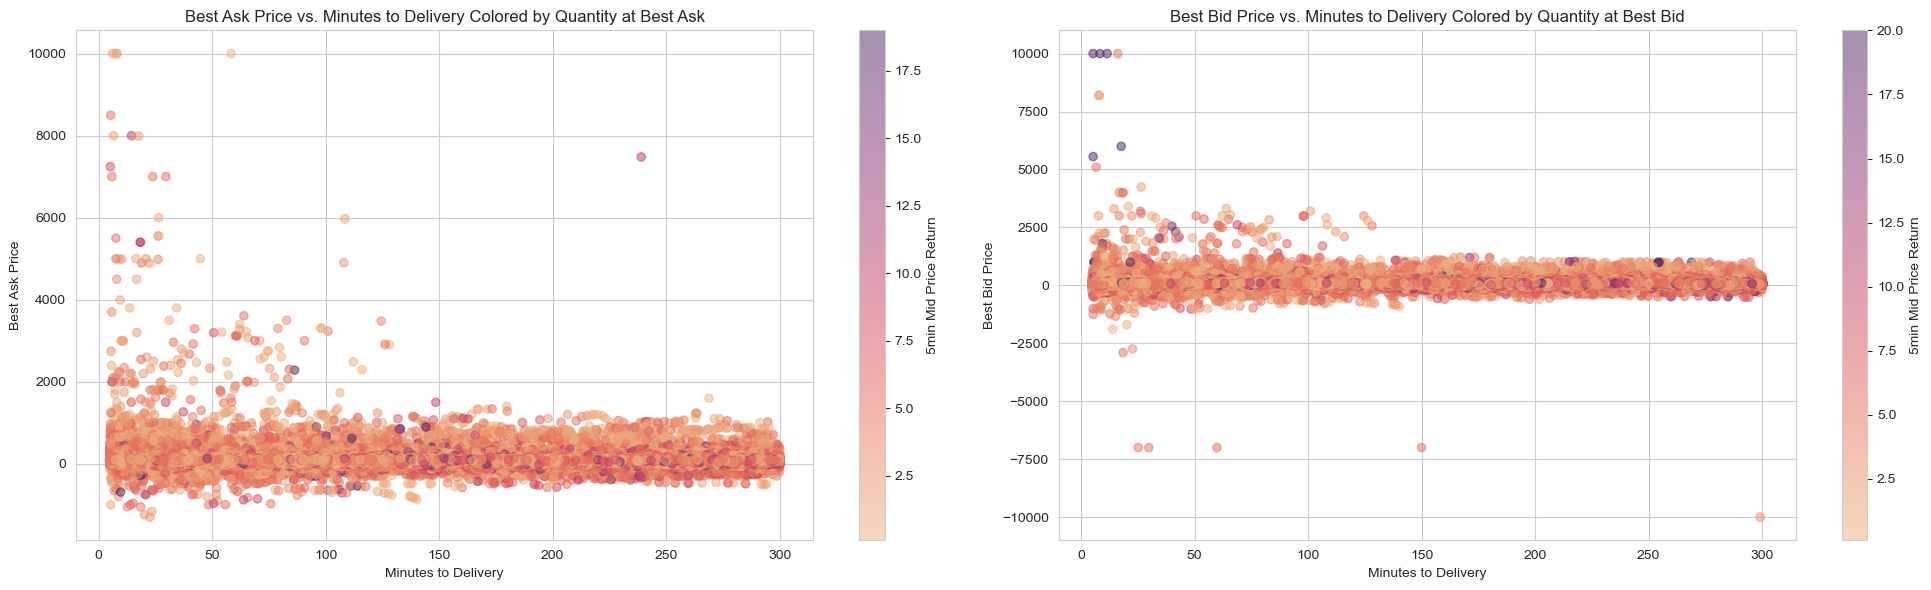

In [26]:
# scatter plot best ask vs time to delivery colored by mid price return

data["ttd_min"] = (data["delivery_start"] - data["snapshot_times"]).dt.total_seconds() / 60
data["ttd_min_bin"] = pd.cut(data["ttd_min"], bins=range(0, 301, 5))

subsample_df = data[
    ["ttd_min", "ttd_min_bin", "price_1_ask", "price_1_bid", "quantity_1_ask", "quantity_1_bid"]].sample(n=1000000,
                                                                                                         random_state=42)

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sc = plt.scatter(
    subsample_df["ttd_min"],
    subsample_df["price_1_ask"],
    c=subsample_df["quantity_1_ask"].clip(
        lower=subsample_df["quantity_1_ask"].quantile(0.01),
        upper=subsample_df["quantity_1_ask"].quantile(0.99)
    ),
    cmap="flare",
    alpha=0.5
)
plt.colorbar(sc, label="5min Mid Price Return")
plt.title("Best Ask Price vs. Minutes to Delivery Colored by Quantity at Best Ask")
plt.xlabel("Minutes to Delivery")
plt.ylabel("Best Ask Price")
plt.subplot(1, 2, 2)
sc = plt.scatter(
    subsample_df["ttd_min"],
    subsample_df["price_1_bid"],
    c=subsample_df["quantity_1_bid"].clip(
        lower=subsample_df["quantity_1_bid"].quantile(0.01),
        upper=subsample_df["quantity_1_bid"].quantile(0.99)
    ),
    cmap="flare",
    alpha=0.5
)
plt.colorbar(sc, label="5min Mid Price Return")
plt.title("Best Bid Price vs. Minutes to Delivery Colored by Quantity at Best Bid")
plt.xlabel("Minutes to Delivery")
plt.ylabel("Best Bid Price")
plt.tight_layout()
plt.show()

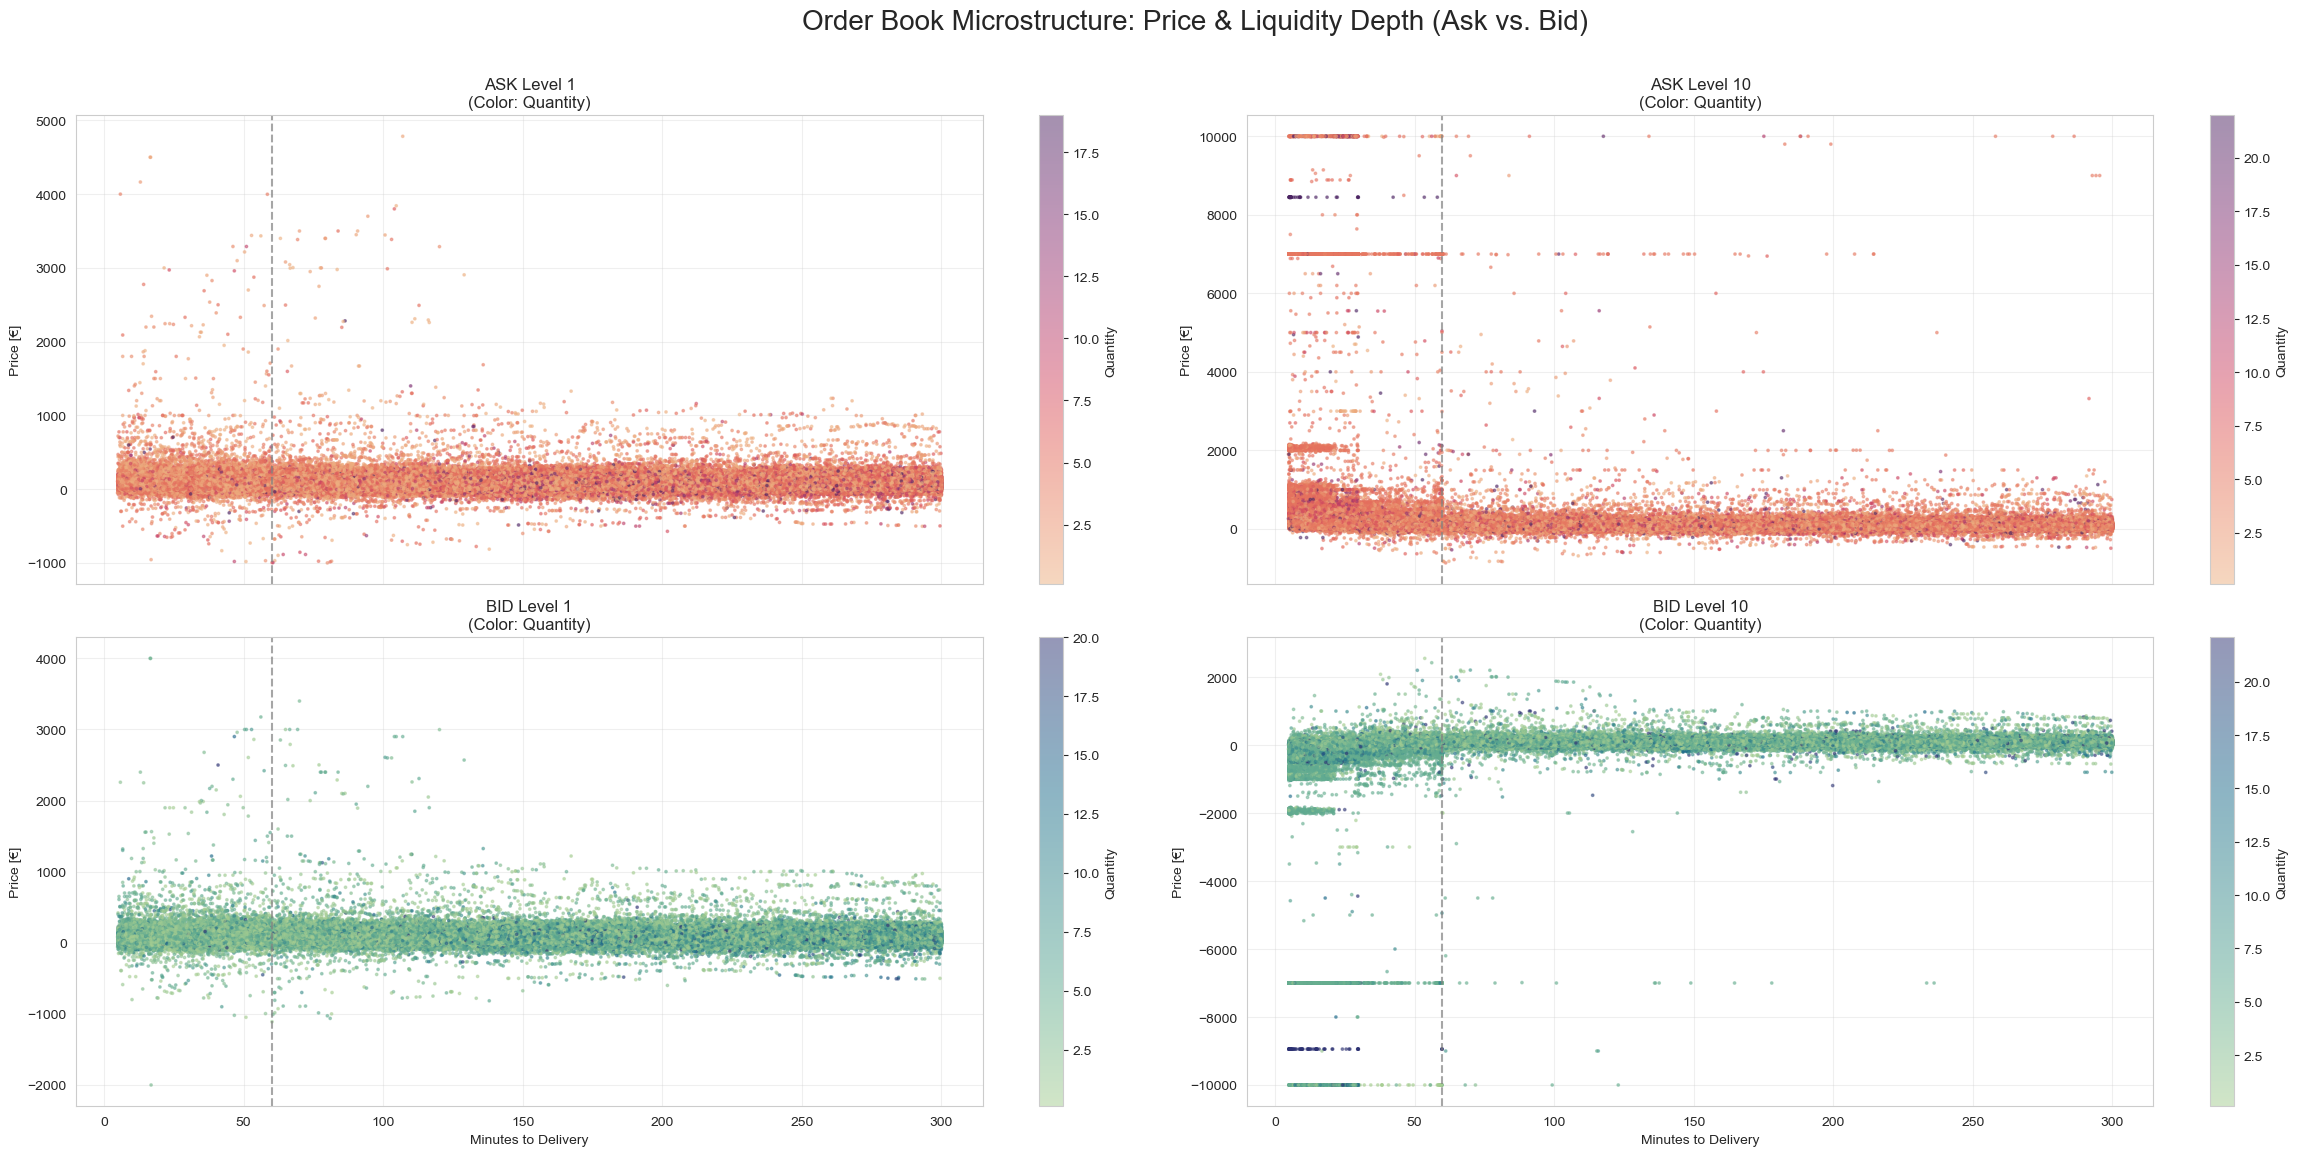

In [109]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. TTD berechnen (falls noch nicht da)
if "ttd_min" not in data.columns:
    data["ttd_min"] = (data["delivery_start"] - data["snapshot_times"]).dt.total_seconds() / 60

# 2. Relevante Spalten & Subsampling
levels = [1, 10]
cols_to_keep = ["ttd_min"]
for lvl in levels:
    cols_to_keep.extend([f"price_{lvl}_ask", f"quantity_{lvl}_ask", f"price_{lvl}_bid", f"quantity_{lvl}_bid"])

# Sample ziehen (1 Mio Punkte)
subsample_df = data[cols_to_keep].dropna().sample(n=1000000, random_state=42)

# 3. Plot Setup: 2 Zeilen (Sides), 3 Spalten (Levels)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12), sharex=True)

# Loop durch die Spalten (Levels)
for i, level in enumerate(levels):
    # --- ROW 0: ASK SIDE ---
    ax_ask = axes[0, i]  # Zeile 0, Spalte i

    # Quantity Clipping für Farbe
    q_ask = subsample_df[f"quantity_{level}_ask"]
    vmin_ask, vmax_ask = q_ask.quantile(0.01), q_ask.quantile(0.99)
    colors_ask = q_ask.clip(lower=vmin_ask, upper=vmax_ask)

    sc_ask = ax_ask.scatter(
        subsample_df["ttd_min"],
        subsample_df[f"price_{level}_ask"],
        c=colors_ask,
        cmap="flare",  # Rötliche Töne für Ask (Verkauf)
        s=3,
        alpha=0.5
    )

    ax_ask.set_title(f"ASK Level {level}\n(Color: Quantity)")
    ax_ask.set_ylabel("Price [€]")
    # add vertical line for sidc closure at 60 minutes
    ax_ask.axvline(x=60, color='gray', linestyle='--', alpha=0.7)
    plt.colorbar(sc_ask, ax=ax_ask, label="Quantity")
    ax_ask.grid(True, alpha=0.3)

    # --- ROW 1: BID SIDE ---
    ax_bid = axes[1, i]  # Zeile 1, Spalte i

    # Quantity Clipping für Farbe
    q_bid = subsample_df[f"quantity_{level}_bid"]
    vmin_bid, vmax_bid = q_bid.quantile(0.01), q_bid.quantile(0.99)
    colors_bid = q_bid.clip(lower=vmin_bid, upper=vmax_bid)

    sc_bid = ax_bid.scatter(
        subsample_df["ttd_min"],
        subsample_df[f"price_{level}_bid"],
        c=colors_bid,
        cmap="crest",  # Bläuliche Töne für Bid (Kauf)
        s=3,
        alpha=0.5
    )

    ax_bid.set_title(f"BID Level {level}\n(Color: Quantity)")
    ax_bid.set_ylabel("Price [€]")
    # add vertical line for sidc closure at 60 minutes
    ax_bid.axvline(x=60, color='gray', linestyle='--', alpha=0.7)
    plt.colorbar(sc_bid, ax=ax_bid, label="Quantity")
    ax_bid.grid(True, alpha=0.3)
    ax_bid.set_xlabel("Minutes to Delivery")

# Titel über alles
plt.suptitle("Order Book Microstructure: Price & Liquidity Depth (Ask vs. Bid)", fontsize=20, y=0.96)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

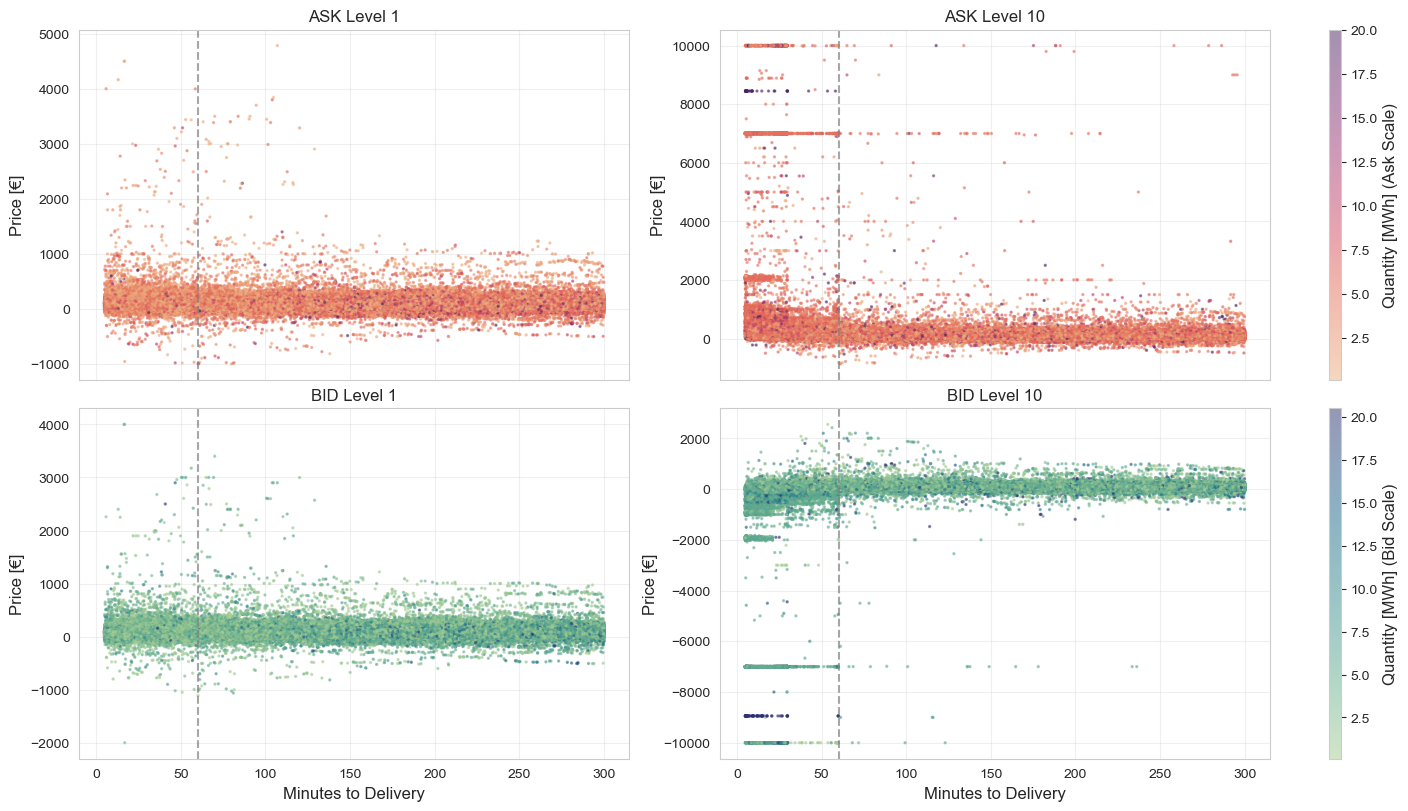

✅ Grafik gespeichert in: figures/orderbook_microstructure_shared_colorbar


In [108]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. TTD & Setup
if "ttd_min" not in data.columns:
    data["ttd_min"] = (data["delivery_start"] - data["snapshot_times"]).dt.total_seconds() / 60

levels = [1, 10]
cols_to_keep = ["ttd_min"]
for lvl in levels:
    cols_to_keep.extend([f"price_{lvl}_ask", f"quantity_{lvl}_ask", f"price_{lvl}_bid", f"quantity_{lvl}_bid"])

subsample_df = data[cols_to_keep].dropna().sample(n=1000000, random_state=42)

# --- 2. GEMEINSAME FARB-SKALEN ---
all_ask_quantities = pd.concat([subsample_df[f"quantity_{l}_ask"] for l in levels])
vmin_ask = all_ask_quantities.quantile(0.01)
vmax_ask = all_ask_quantities.quantile(0.99)

all_bid_quantities = pd.concat([subsample_df[f"quantity_{l}_bid"] for l in levels])
vmin_bid = all_bid_quantities.quantile(0.01)
vmax_bid = all_bid_quantities.quantile(0.99)

# --- 3. PLOTTING ---
# WICHTIG: layout="constrained" verhindert das Überlappen der Colorbars!
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8), sharex=True, layout="constrained")

sc_ask_handle = None
sc_bid_handle = None

for i, level in enumerate(levels):
    # --- ROW 0: ASK SIDE ---
    ax_ask = axes[0, i]

    sc_ask = ax_ask.scatter(
        subsample_df["ttd_min"],
        subsample_df[f"price_{level}_ask"],
        c=subsample_df[f"quantity_{level}_ask"],
        vmin=vmin_ask, vmax=vmax_ask,
        cmap="flare",
        s=2,
        alpha=0.5,
        rasterized=True  # convert to raster for performance
    )
    sc_ask_handle = sc_ask

    ax_ask.set_title(f"ASK Level {level}", fontsize=12)
    ax_ask.set_ylabel("Price [€]", fontsize=12)
    ax_ask.axvline(x=60, color='gray', linestyle='--', alpha=0.7)
    ax_ask.grid(True, alpha=0.3)
    ax_ask.tick_params(axis='both', which='major', labelsize=10)

    # --- ROW 1: BID SIDE ---
    ax_bid = axes[1, i]

    sc_bid = ax_bid.scatter(
        subsample_df["ttd_min"],
        subsample_df[f"price_{level}_bid"],
        c=subsample_df[f"quantity_{level}_bid"],
        vmin=vmin_bid, vmax=vmax_bid,
        cmap="crest",
        s=2,
        alpha=0.5,
        rasterized=True  # convert to raster for performance
    )
    sc_bid_handle = sc_bid

    ax_bid.set_title(f"BID Level {level}", fontsize=12)
    ax_bid.set_ylabel("Price [€]", fontsize=12)
    ax_bid.axvline(x=60, color='gray', linestyle='--', alpha=0.7)
    ax_bid.grid(True, alpha=0.3)
    ax_bid.tick_params(axis='both', which='major', labelsize=10)
    ax_bid.set_xlabel("Minutes to Delivery", fontsize=12)

# --- 4. COLORBARS ---

# Colorbar für die obere Reihe (Ask)
# shrink=0.8 macht die Bar etwas kleiner, damit sie ästhetischer aussieht
cb_ask = fig.colorbar(sc_ask_handle, ax=axes[0, :], aspect=30, location='right')
cb_ask.set_label("Quantity [MWh] (Ask Scale)", fontsize=12)

# Colorbar für die untere Reihe (Bid)
cb_bid = fig.colorbar(sc_bid_handle, ax=axes[1, :], aspect=30, location='right')
cb_bid.set_label("Quantity [MWh] (Bid Scale)", fontsize=12)

# KEIN plt.tight_layout() mehr nötig, layout="constrained" regelt das!
plt.show()

save_plot(fig, "orderbook_microstructure_shared_colorbar")

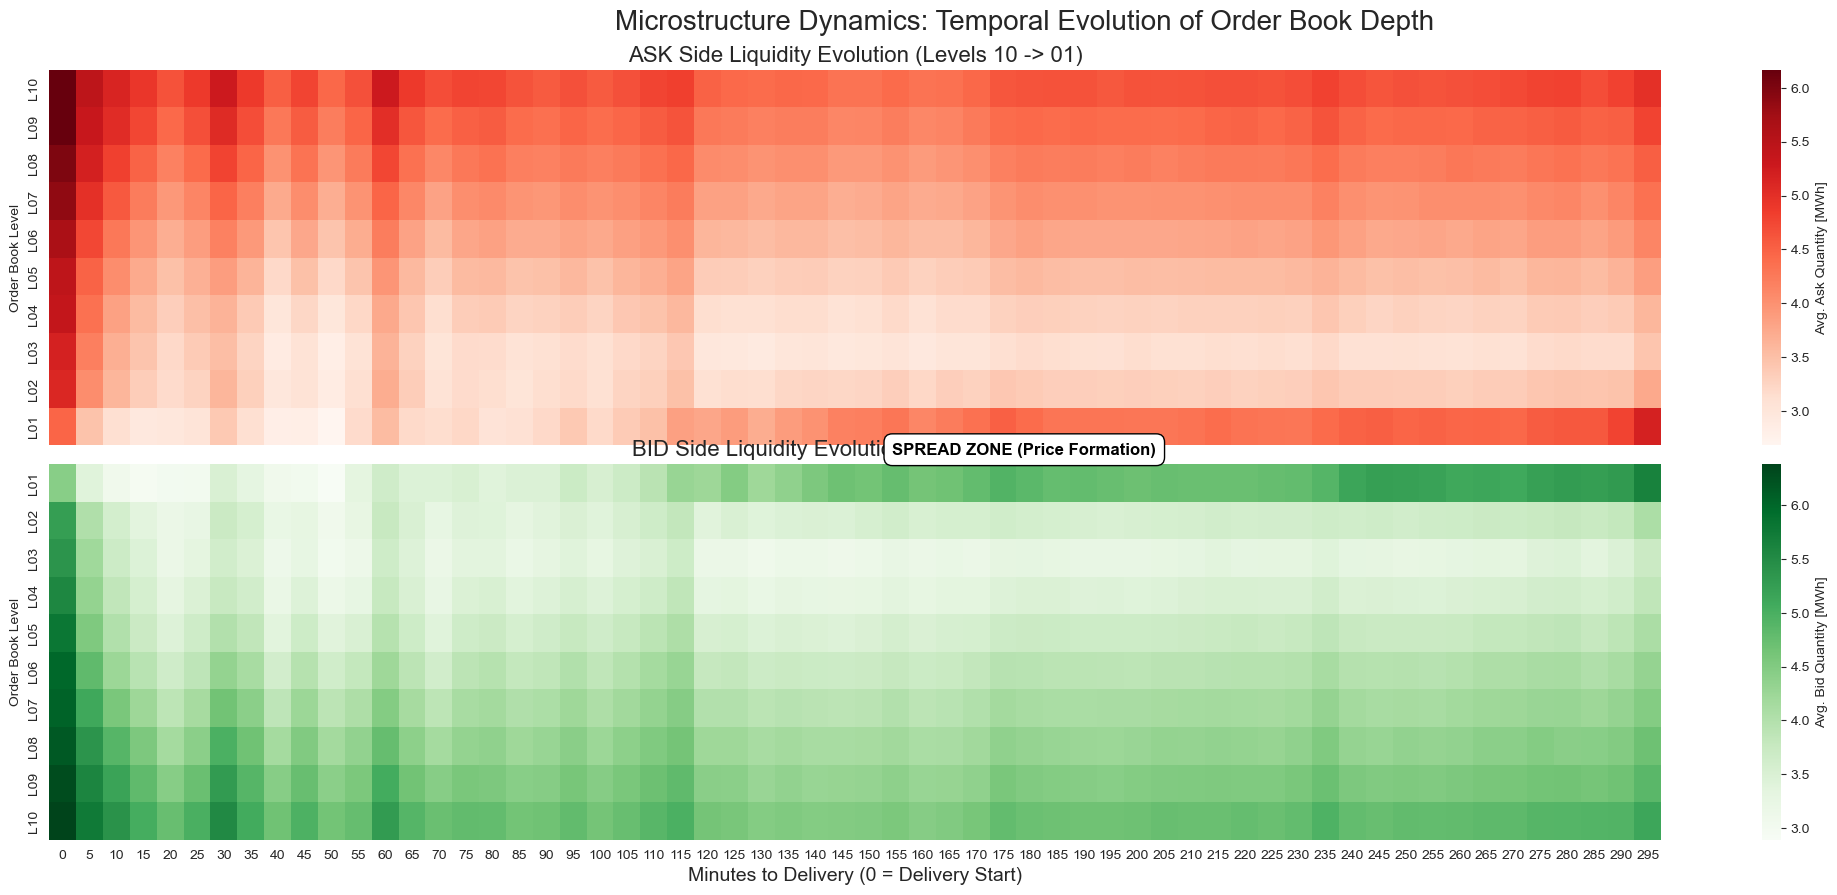

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- 1. DATEN AGGREGATION ---

# Falls noch nicht vorhanden: TTD berechnen
if "ttd_min" not in data.columns:
    data["ttd_min"] = (data["delivery_start"] - data["snapshot_times"]).dt.total_seconds() / 60

# Bins erstellen (5-Minuten Schritte)
bins = range(0, 305, 5)
labels = [f"{i}" for i in bins[:-1]]
data["ttd_heatmap_bin"] = pd.cut(data["ttd_min"], bins=bins, labels=labels)

ask_layers = []
bid_layers = []
levels = range(1, 11)

# Grouping vorbereiten
grouped = data.groupby("ttd_heatmap_bin", observed=True)

for lvl in levels:
    # DER FIX: f"{lvl:02d}" sorgt für "L01", "L02" ... "L10"
    label_name = f"L{lvl:02d}"

    # Ask Data
    ask_series = grouped[f"quantity_{lvl}_ask"].mean()
    ask_series.name = label_name
    ask_layers.append(ask_series)

    # Bid Data
    bid_series = grouped[f"quantity_{lvl}_bid"].mean()
    bid_series.name = label_name
    bid_layers.append(bid_series)

# DataFrames erstellen
# ---------------------------------------------------------
# WICHTIG FÜR DIE OPTIK (Das Sandwich):
# Ask: Wir wollen L01 unten (beim Preis) und L10 oben haben.
# Da Heatmaps Index 0 oben plotten, sortieren wir absteigend (L10 -> L01).
df_ask_heat = pd.DataFrame(ask_layers).sort_index(ascending=False)

# Bid: Wir wollen L01 oben (beim Preis) und L10 unten haben.
# Wir sortieren aufsteigend (L01 -> L10).
df_bid_heat = pd.DataFrame(bid_layers).sort_index(ascending=True)
# ---------------------------------------------------------

# --- 2. PLOTTING ---
fig, (ax_ask, ax_bid) = plt.subplots(2, 1, figsize=(26, 10), sharex=True)

# A) ASK HEATMAP (Oben - Rot)
sns.heatmap(df_ask_heat, ax=ax_ask, cmap="Reds", cbar_kws={'label': 'Avg. Ask Quantity [MWh]'})
ax_ask.set_title("ASK Side Liquidity Evolution (Levels 10 -> 01)", fontsize=16)
ax_ask.set_ylabel("Order Book Level")
ax_ask.set_xlabel("")

# B) BID HEATMAP (Unten - Grün)
sns.heatmap(df_bid_heat, ax=ax_bid, cmap="Greens", cbar_kws={'label': 'Avg. Bid Quantity [MWh]'})
ax_bid.set_title("BID Side Liquidity Evolution (Levels 01 -> 10)", fontsize=16)
ax_bid.set_ylabel("Order Book Level")
ax_bid.set_xlabel("Minutes to Delivery (0 = Delivery Start)", fontsize=14)

# Layout: Lücke minimieren
plt.subplots_adjust(hspace=0.05)

# Titel
plt.suptitle("Microstructure Dynamics: Temporal Evolution of Order Book Depth", fontsize=20, y=0.94)

# Annotation für "Mid Price / Spread"
# Wir platzieren den Text genau zwischen die beiden Plots (y=0.5 in Figure-Koordinaten)
fig.text(0.5, 0.5, "SPREAD ZONE (Price Formation)", ha='center', va='center',
         fontsize=12, fontweight='bold', color='black',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.show()

<>:57: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\m'
/var/folders/_g/t9jm9x4n7v313q5_zspldllr0000gn/T/ipykernel_41051/2352444798.py:57: SyntaxWarning: invalid escape sequence '\m'
  label=f'Normal ($\mu$={mu:.2f})')


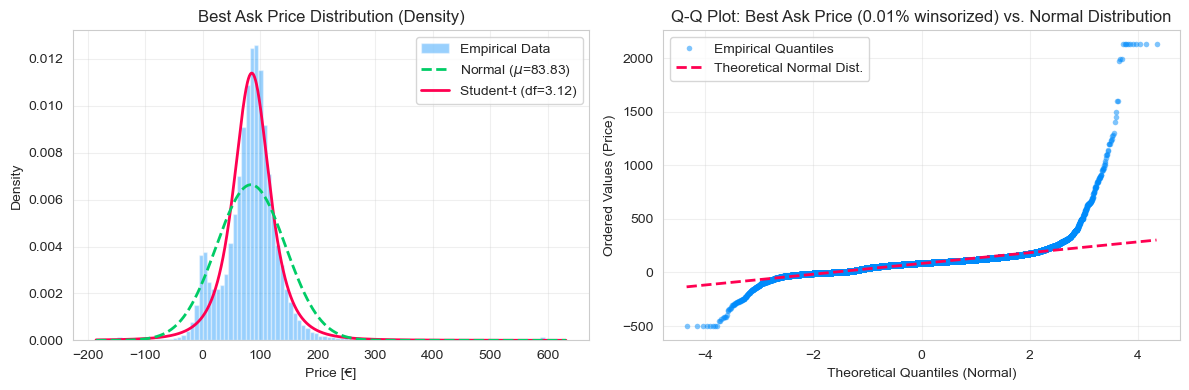

✅ Grafik gespeichert in: figures/price_distribution_qqplot


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

# Farben & Config
SHAP_RED = "#ff0051"
SHAP_BLUE = "#008bfb"
NORM_GREEN = "#00cc66"
FIT_SAMPLE_SIZE = 100000  # Subsample für Performance bei Fit & QQ-Plot


def get_safe_clean_data(series, threshold=1e9):
    # Numerik erzwingen, Infs und NaNs entfernen
    s = pd.to_numeric(series, errors='coerce').astype('float64')
    s = s[np.isfinite(s)]
    # Unmögliche Werte filtern (Overflow-Schutz)
    s = s[np.abs(s) < threshold]
    return s


# Figure Setup
fig = plt.figure(figsize=(12, 4))

# Daten laden & bereinigen
try:
    prices = get_safe_clean_data(data["price_1_ask"])

    # Subsample erstellen (für Fit UND QQ-Plot, da QQ bei Millionen Punkten ewig dauert)
    if len(prices) > FIT_SAMPLE_SIZE:
        prices_sample = prices.sample(n=FIT_SAMPLE_SIZE, random_state=42)
    else:
        prices_sample = prices

    prices_sample = prices_sample.clip(
        lower=prices.quantile(0.0001),
        upper=prices.quantile(0.9999)
    )

    # ---------------------------------------------------------
    # PLOT 1: HISTOGRAMM & FITS (Links)
    # ---------------------------------------------------------
    plt.subplot(1, 2, 1)

    # Histogramm (Optik: Clipping 0.1% - 99.9%)
    lower, upper = prices.quantile(0.001), prices.quantile(0.999)
    prices_plot = prices.clip(lower=lower, upper=upper)
    plt.hist(prices_plot, bins=100, density=True, alpha=0.4, color=SHAP_BLUE, label='Empirical Data')

    # X-Achse für Kurven
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 1000)

    # Normal Fit
    mu, std = stats.norm.fit(prices_sample)
    plt.plot(x, stats.norm.pdf(x, mu, std), color=NORM_GREEN, linestyle='--', linewidth=2, zorder=10,
             label=f'Normal ($\mu$={mu:.2f})')

    # Student-t Fit
    try:
        df, loc, scale = stats.t.fit(prices_sample)
        plt.plot(x, stats.t.pdf(x, df, loc, scale), color=SHAP_RED, linewidth=2, zorder=9,
                 label=f'Student-t (df={df:.2f})')
    except Exception as e:
        print(f"Fit Error: {e}")

    plt.title("Best Ask Price Distribution (Density)")
    plt.xlabel("Price [€]")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # ---------------------------------------------------------
    # PLOT 2: Q-Q PLOT (Rechts)
    # ---------------------------------------------------------
    plt.subplot(1, 2, 2)

    # Q-Q Plot gegen Normalverteilung erstellen
    # Wir nutzen das Subsample, sonst rendert Matplotlib Millionen von Punkten -> Crash
    (osm, osr), (slope, intercept, r) = stats.probplot(prices_sample, dist="norm", plot=plt)

    # Styling anpassen (Standard Scipy Plot ist blau, wir passen es an)
    # Zugriff auf die Elemente des Plots:
    # Line 0: Die Punkte (Daten)
    # Line 1: Die rote Linie (Theoretische Normalverteilung)
    ax = plt.gca()
    lines = ax.get_lines()

    # Punkte stylen
    if len(lines) > 0:
        lines[0].set_markerfacecolor(SHAP_BLUE)
        lines[0].set_markeredgewidth(0)
        lines[0].set_markersize(4)
        lines[0].set_alpha(0.5)
        lines[0].set_label("Empirical Quantiles")

    # Linie stylen
    if len(lines) > 1:
        lines[1].set_color(SHAP_RED)
        lines[1].set_linewidth(2)
        lines[1].set_linestyle('--')
        lines[1].set_label("Theoretical Normal Dist.")

    plt.title("Q-Q Plot: Best Ask Price (0.01% winsorized) vs. Normal Distribution")
    plt.xlabel("Theoretical Quantiles (Normal)")
    plt.ylabel("Ordered Values (Price)")
    plt.grid(True, alpha=0.3)
    plt.legend()



except Exception as e:
    plt.text(0.5, 0.5, f"Data Error: {e}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

save_plot(fig, "price_distribution_qqplot")

--- START DEBUGGING ---
Zeilen vor Bereinigung: 22344778
Zeilen nach NaN/Inf Drop: 22289805
Zeilen nach Value-Filter: 22286686
Vorschau der Plot-Daten:
     Price_CV_Smooth Quantity_CV_Smooth
                                       
bin                                    
0.0         2.011375           1.392625
5.0         1.651644           1.264670
10.0        0.929256           1.028549
15.0        0.900850           1.025413
20.0        0.871754           1.033742


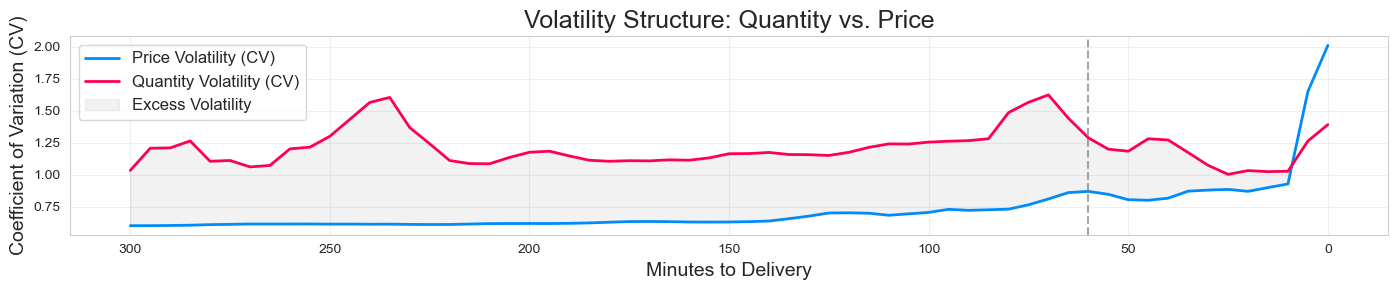

✅ Grafik gespeichert in: figures/volatility_structure_price_quantity


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1. DATEN KOPIEREN & BEREINIGEN ---
print("--- START DEBUGGING ---")
cols = ["price_1_ask", "quantity_1_ask", "delivery_start", "snapshot_times"]
df_plot = data[cols].copy()

# TTD berechnen
df_plot["ttd_min"] = (df_plot["delivery_start"] - df_plot["snapshot_times"]).dt.total_seconds() / 60

# Alles zu Float wandeln
for col in ["price_1_ask", "quantity_1_ask", "ttd_min"]:
    df_plot[col] = pd.to_numeric(df_plot[col], errors='coerce')

# WICHTIG: Urspungs-Länge
print(f"Zeilen vor Bereinigung: {len(df_plot)}")

# Filter 1: Infs und NaNs entfernen
df_plot = df_plot.replace([np.inf, -np.inf], np.nan).dropna()
print(f"Zeilen nach NaN/Inf Drop: {len(df_plot)}")

# Filter 2: Realistische Wertebereiche erzwingen (Nuklear-Option gegen Overflow)
# Preise: -500 bis 4000 (alles andere killt die Varianz)
# Mengen: 0 bis 5000
df_plot = df_plot[
    (df_plot["price_1_ask"] > -500) & (df_plot["price_1_ask"] < 4000) &
    (df_plot["quantity_1_ask"] >= 0) & (df_plot["quantity_1_ask"] < 5000) &
    (df_plot["ttd_min"] >= 0) & (df_plot["ttd_min"] <= 305)
    ]
print(f"Zeilen nach Value-Filter: {len(df_plot)}")

# --- 2. AGGREGATION (VEKTORISIERT) ---
# Wir gruppieren und berechnen Mean und Std getrennt. Das crasht nicht.
df_plot["bin"] = (df_plot["ttd_min"] // 5) * 5

# Hier passiert die Magie: Groupby berechnet Mean und Std optimiert in C
grouped = df_plot.groupby("bin")[["price_1_ask", "quantity_1_ask"]].agg(["mean", "std"])

# --- 3. CV BERECHNUNG (NACHTRÄGLICH) ---
# CV = std / abs(mean)
# Wir arbeiten jetzt mit dem kleinen 'grouped' DataFrame (nur ~60 Zeilen), das geht instant.

# Zugriff auf MultiIndex Spalten: ('price_1_ask', 'std')
grouped["Price_CV"] = grouped[("price_1_ask", "std")] / grouped[("price_1_ask", "mean")].abs()
grouped["Quantity_CV"] = grouped[("quantity_1_ask", "std")] / grouped[("quantity_1_ask", "mean")].abs()

# Filter: Wenn Mean nahe 0 ist, explodiert CV -> Raus damit
grouped = grouped[grouped[("price_1_ask", "mean")].abs() > 1.0]

# Glätten (Smooth)
grouped["Price_CV_Smooth"] = grouped["Price_CV"].rolling(3, center=True, min_periods=1).mean()
grouped["Quantity_CV_Smooth"] = grouped["Quantity_CV"].rolling(3, center=True, min_periods=1).mean()

print("Vorschau der Plot-Daten:")
print(grouped[["Price_CV_Smooth", "Quantity_CV_Smooth"]].head())

# --- 4. PLOTTING ---
fig, ax1 = plt.subplots(figsize=(14, 3))

# Index ist jetzt 'bin' (0, 5, 10...)
x_vals = grouped.index

if len(x_vals) > 0:
    # A) Plots
    ax1.plot(x_vals, grouped["Price_CV_Smooth"], color=SHAP_BLUE, linewidth=2, label="Price Volatility (CV)")
    ax1.plot(x_vals, grouped["Quantity_CV_Smooth"], color=SHAP_RED, linewidth=2, label="Quantity Volatility (CV)")

    # B) Fill Between
    ax1.fill_between(x_vals,
                     grouped["Price_CV_Smooth"],
                     grouped["Quantity_CV_Smooth"],
                     where=(grouped["Quantity_CV_Smooth"] > grouped["Price_CV_Smooth"]),
                     color="gray", alpha=0.1, interpolate=True, label="Excess Volatility")

    ax1.set_xlabel("Minutes to Delivery", fontsize=14)
    ax1.set_ylabel("Coefficient of Variation (CV)", fontsize=14)
    ax1.set_title("Volatility Structure: Quantity vs. Price", fontsize=18)
    ax1.invert_xaxis()  # 300 -> 0
    ax1.legend(loc='upper left', fontsize=12)
    ax1.grid(True, alpha=0.3)

    # C) Vertikale Linie bei 60 Minuten
    ax1.axvline(x=60, color='gray', linestyle='--', alpha=0.7)

    # Annotation (sicherer Zugriff)
    try:
        # Wir suchen den Index, der am nächsten an 60 liegt
        idx_node = x_vals.get_indexer([60], method='nearest')[0]
        val_idx = x_vals[idx_node]  # Der echte Index-Wert (z.B. 60.0)

        # Werte holen
        val_p = grouped.loc[val_idx, "Price_CV_Smooth"]
        val_q = grouped.loc[val_idx, "Quantity_CV_Smooth"]

        ax1.annotate(f'Qty Volatility: {val_q:.2f}\nPrice Volatility: {val_p:.2f}',
                     xy=(val_idx, val_q), xytext=(val_idx + 40, val_q + 0.5),
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     fontsize=12, bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
    except:
        pass

else:
    ax1.text(0.5, 0.5, "Keine Daten nach Filterung!", ha='center', fontsize=20)

plt.tight_layout()
plt.show()

save_plot(fig, "volatility_structure_price_quantity")

✅ Grafik gespeichert in: figures/seasonality_heatmap_a4


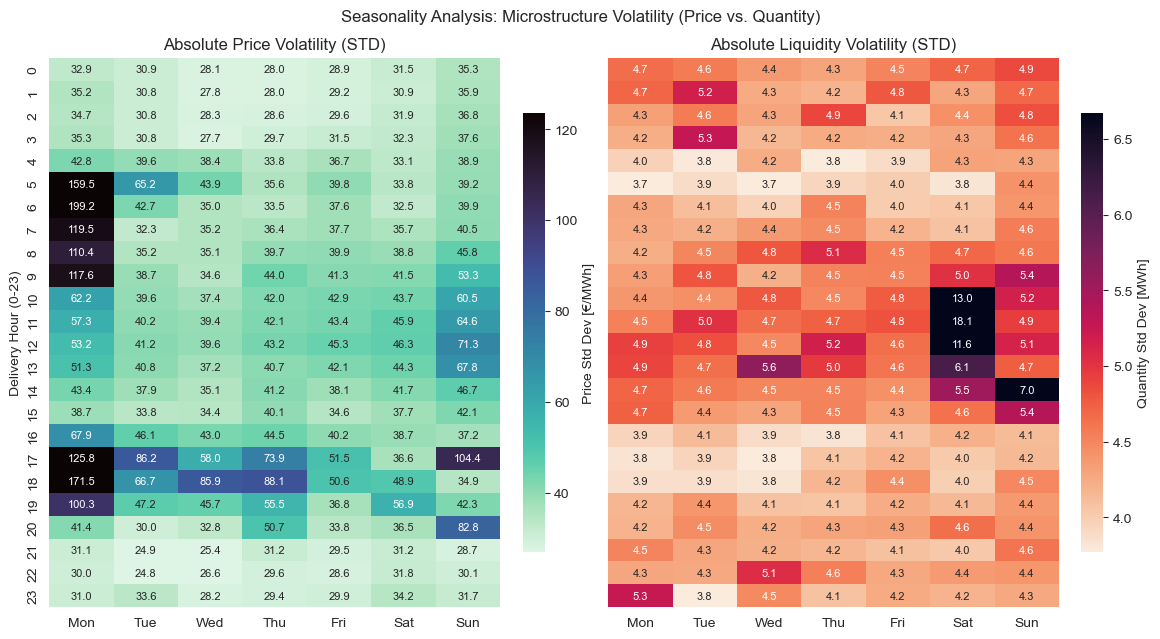

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm  # Wichtig für Option B

# ... (Dein Data Prep Code bleibt identisch bis zum Plotting) ...

# --- 3. PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11.5, 6), sharey=True, layout="constrained")

title_fs = 12
label_fs = 10
annot_fs = 8

# WICHTIG FÜR LOG-SCALE:
# Logarithmus von 0 ist -unendlich. Da wir .fillna(0) haben, müssen wir
# sicherstellen, dass keine 0 in die LogNorm kommt, sonst crasht es.
# Wir addieren ein Epsilon (0.01) nur für die Darstellung, falls Log gewählt wird.

# --- OPTION A: ROBUST LINEAR (Empfohlen für Thesis) ---
# robust=True berechnet vmin/vmax basierend auf Perzentilen (2% - 98%).
# Extreme Ausreißer machen so nicht das ganze Bild kaputt.
heatmap_kwargs = {
    "annot": True,
    "fmt": ".1f",
    "annot_kws": {"size": annot_fs},
    "robust": True  # <--- DER TRICK
}

# --- OPTION B: LOGARITHMISCH (Nur nutzen, wenn Option A nicht reicht) ---
# Falls du das nutzen willst, einkommentieren und Option A kwargs löschen.
# heatmap_kwargs = {
#     "annot": True,
#     "fmt": ".1f",
#     "annot_kws": {"size": annot_fs},
#     "norm": LogNorm(vmin=0.1, vmax=None) # Logarithmische Farbskala
# }


# --- PLOT 1: PREIS ---
# Falls LogNorm genutzt wird, müssen Nullen abgefangen werden:
plot_data_price = heatmap_price if "norm" not in heatmap_kwargs else heatmap_price + 0.01

sns.heatmap(plot_data_price, ax=ax1, cmap="mako_r",
            cbar_kws={'label': 'Price Std Dev [€/MWh]', 'shrink': 0.8},
            **heatmap_kwargs)  # Hier werden die Optionen reingeladen

ax1.set_title("Absolute Price Volatility (STD)", fontsize=title_fs)
ax1.set_ylabel("Delivery Hour (0-23)", fontsize=label_fs)
ax1.set_xlabel("")
ax1.tick_params(axis='x', rotation=0)

# --- PLOT 2: MENGE ---
plot_data_qty = heatmap_qty if "norm" not in heatmap_kwargs else heatmap_qty + 0.01

sns.heatmap(plot_data_qty, ax=ax2, cmap="rocket_r",
            cbar_kws={'label': 'Quantity Std Dev [MWh]', 'shrink': 0.8},
            **heatmap_kwargs)

ax2.set_title("Absolute Liquidity Volatility (STD)", fontsize=title_fs)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.tick_params(axis='x', rotation=0)

plt.suptitle("Seasonality Analysis: Microstructure Volatility (Price vs. Quantity)",
             fontsize=12, y=1.04)

save_plot(fig, "seasonality_heatmap_a4")
plt.show()